SHAP 이용 CO2RR 공정 분석 시작

SHAP 라이브러리 버전: 0.48.0
Scikit-learn 라이브러리 버전: 1.7.1

SHAP 값 계산이 성공적으로 완료되었습니다.


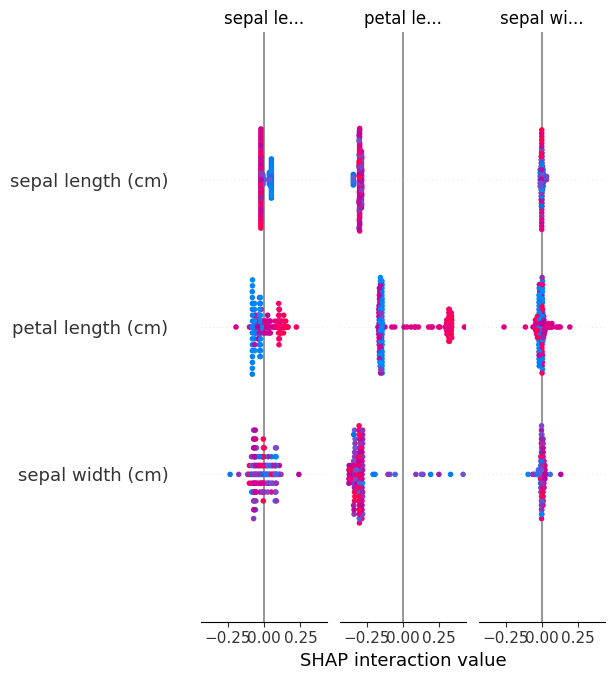

In [2]:
import shap
import sklearn
from sklearn.ensemble import RandomForestClassifier

print(f"SHAP 라이브러리 버전: {shap.__version__}")
print(f"Scikit-learn 라이브러리 버전: {sklearn.__version__}")

# 간단한 모델 학습
X, y = shap.datasets.iris()
model = RandomForestClassifier()
model.fit(X, y)

# Explainer 생성 및 SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 간단한 결과 출력
print("\nSHAP 값 계산이 성공적으로 완료되었습니다.")
shap.summary_plot(shap_values, X) # 시각화를 원할 경우 주석 해제
